In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config, GrokkingLearner, GrokkingConfig

from toy_models.fit import rescale_run, Pattern, PatternLearningModel, fit_sweep

from unifying.sweep import get_history, handle_outliers

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")

zsh:1: /Users/Jesse/Projects/pattern-learning/.venv/bin/pip: bad interpreter: /Users/Jesse/Projects/unifying-grok-dd/.venv/bin/python: no such file or directory


In [2]:
rw_grokking = get_history("2peyz0vr", "oxsp97s3", unique_cols="weight_decay")
rw_grokking_cleaned = handle_outliers(
    rw_grokking,
    loss_cols=["train/loss"], 
    action="remove",
    unique_cols=["weight_decay"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)

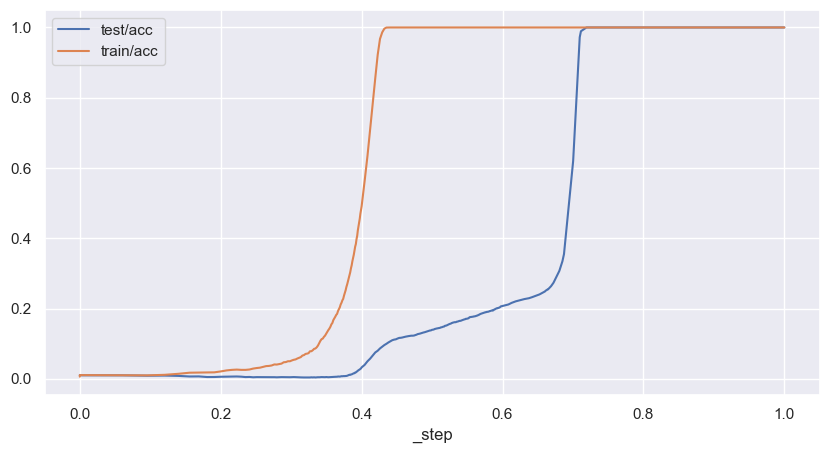

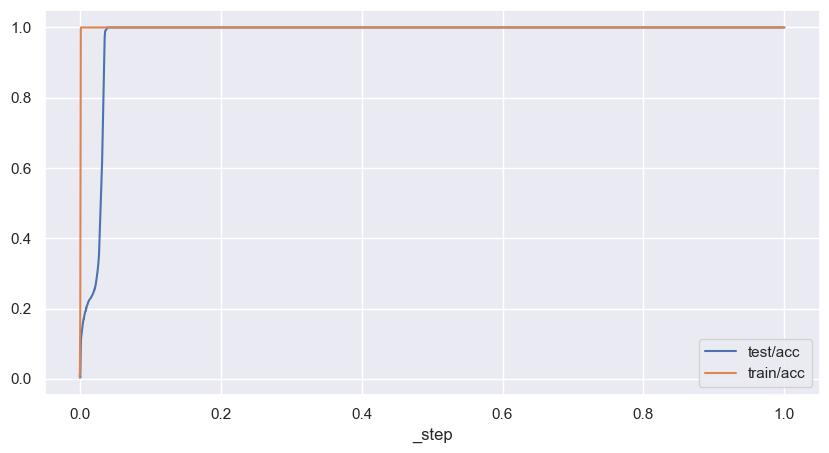

In [53]:
wds = rw_grokking_cleaned.weight_decay.unique()
run = rw_grokking_cleaned[rw_grokking_cleaned.weight_decay == wds[-1]]


rescaled_run = rescale_run(run)
rescaled_run.plot(x="_step", y=["test/acc", "train/acc"], figsize=(10, 5))
plt.show()

rescaled_run_2 = rescale_run(run, log=False)
rescaled_run_2.plot(x="_step", y=["test/acc", "train/acc"], figsize=(10, 5))
plt.show()

In [12]:
run.sort_values(by="_step", inplace=True)
run

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_27965/3039323060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run.sort_values(by="_step", inplace=True)


,weight/dist_from_init,_runtime,test/acc,test/loss,train/efficiency,_step,_timestamp,train/loss,weight/norm,train/acc,...,num_ctx,num_heads,batch_size,frac_train,num_layers,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion
0,0.000000,3.039697,0.010292,4.769397e+00,1.129869e-01,1.0,1.683210e+09,4.771011e+00,42.226231,0.006005,...,3,4,3830,0.3,1,5,1.65063,0,1000,1.0
1,0.459684,3.313967,0.009845,4.751454e+00,1.124916e-01,1.0,1.683210e+09,4.741370e+00,42.148644,0.010444,...,3,4,3830,0.3,1,5,1.65063,0,1000,1.0
2,0.835154,3.433091,0.009733,4.748953e+00,1.123738e-01,2.0,1.683210e+09,4.728404e+00,42.077475,0.009922,...,3,4,3830,0.3,1,5,1.65063,0,1000,1.0
3,1.167947,3.659834,0.008726,4.751540e+00,1.123893e-01,3.0,1.683210e+09,4.721593e+00,42.011047,0.009661,...,3,4,3830,0.3,1,5,1.65063,0,1000,1.0
4,1.465245,3.895840,0.009061,4.754801e+00,1.124342e-01,4.0,1.683210e+09,4.716391e+00,41.948020,0.011227,...,3,4,3830,0.3,1,5,1.65063,0,1000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,49.686544,7898.306144,1.000000,3.612317e-07,5.653108e-09,98790.0,1.682812e+09,1.685032e-07,29.807173,1.000000,...,3,4,3830,0.3,1,10,1.65063,0,100000,1.0
280,49.686567,7902.395248,1.000000,3.622982e-07,5.651247e-09,98840.0,1.682812e+09,1.684455e-07,29.806780,1.000000,...,3,4,3830,0.3,1,10,1.65063,0,100000,1.0
87,49.688340,7928.892034,1.000000,3.653664e-07,5.661224e-09,99170.0,1.682812e+09,1.687458e-07,29.807301,1.000000,...,3,4,3830,0.3,1,10,1.65063,0,100000,1.0
231,49.689427,7955.295583,1.000000,3.653653e-07,5.667867e-09,99500.0,1.682812e+09,1.689397e-07,29.806569,1.000000,...,3,4,3830,0.3,1,10,1.65063,0,100000,1.0


/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


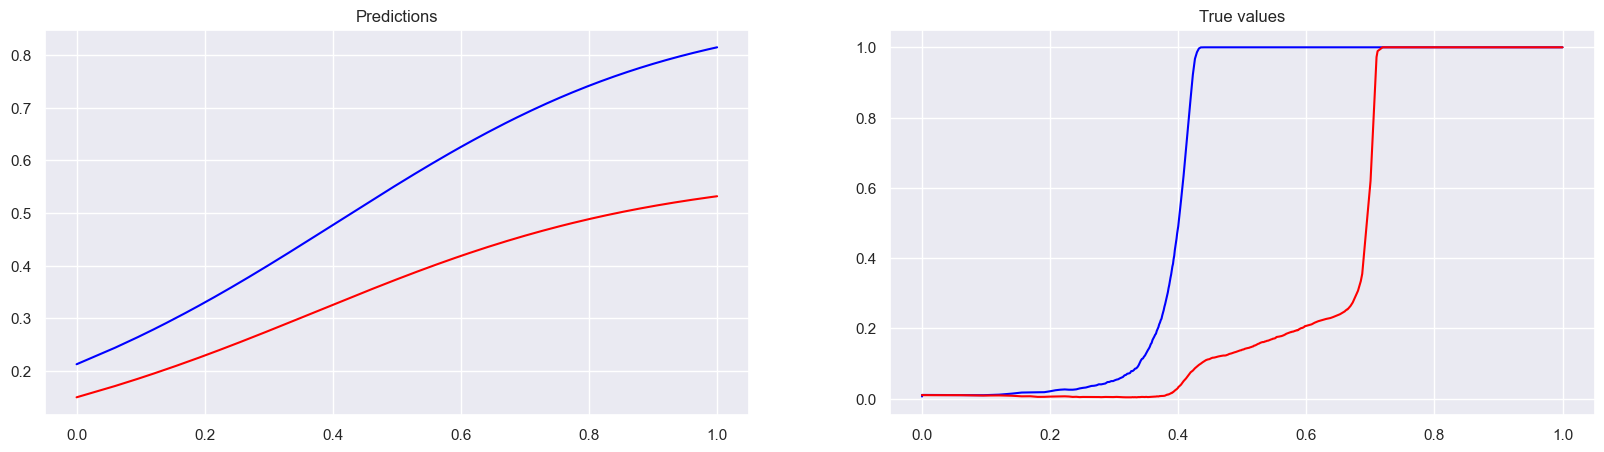

In [54]:


torch.manual_seed(1)
pl_model = PatternLearningModel(max_time=1.)

def plot_patterns(pl_model):
    ts = rescaled_run["_step"].values
    train_preds = [pl_model(t).detach().numpy() for t in ts]
    test_preds = [pl_model.test(t).detach().numpy() for t in ts]
    train_ys = torch.tensor(rescaled_run["train/acc"].values).float()
    test_ys = torch.tensor(rescaled_run["test/acc"].values).float()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(ts, train_preds, label="train", color="blue")
    axes[0].plot(ts, test_preds, label="test", color="red")

    axes[1].plot(ts, train_ys, label="train", color="blue")
    axes[1].plot(ts, test_ys, label="test", color="red")

    axes[0].set_title("Predictions")
    axes[1].set_title("True values")

    # axes[0].set_xscale("log")
    # axes[1].set_xscale("log")
plt.show()

plot_patterns(pl_model)

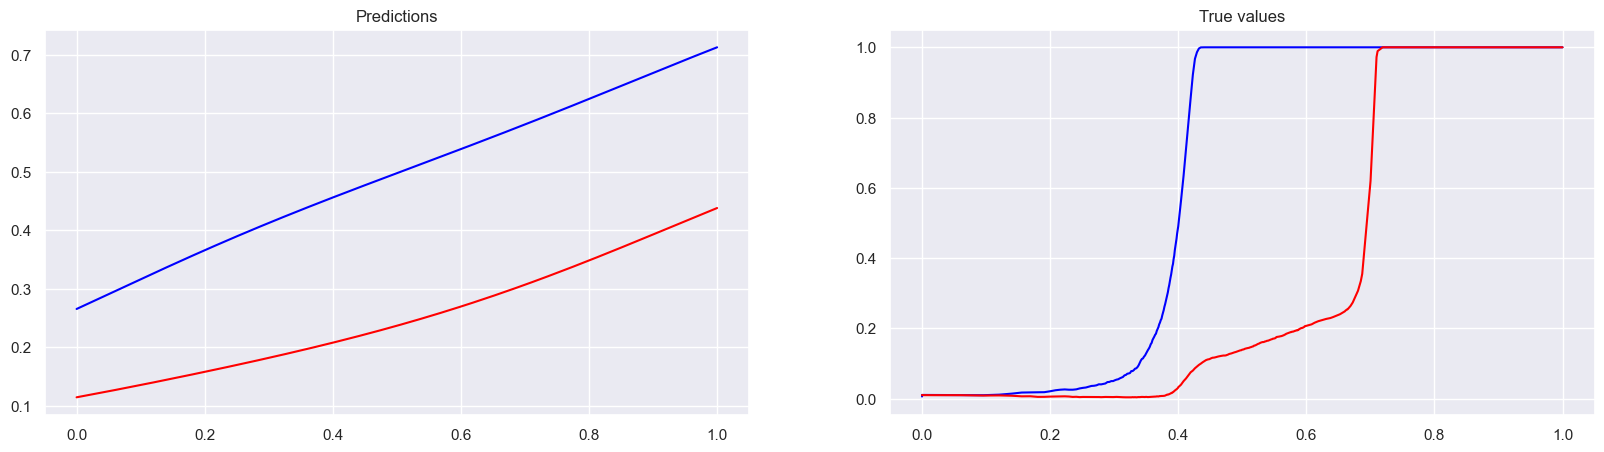

TS torch.Size([772])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 - loss: 0.3598639965057373


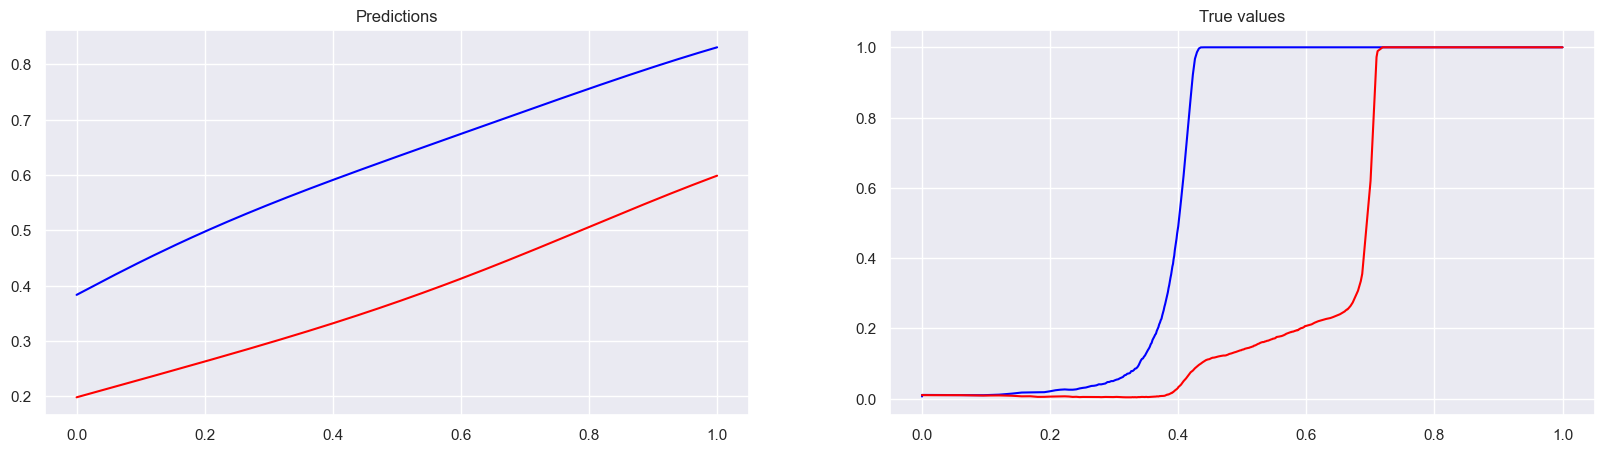

Epoch 1 - loss: 0.2186661958694458


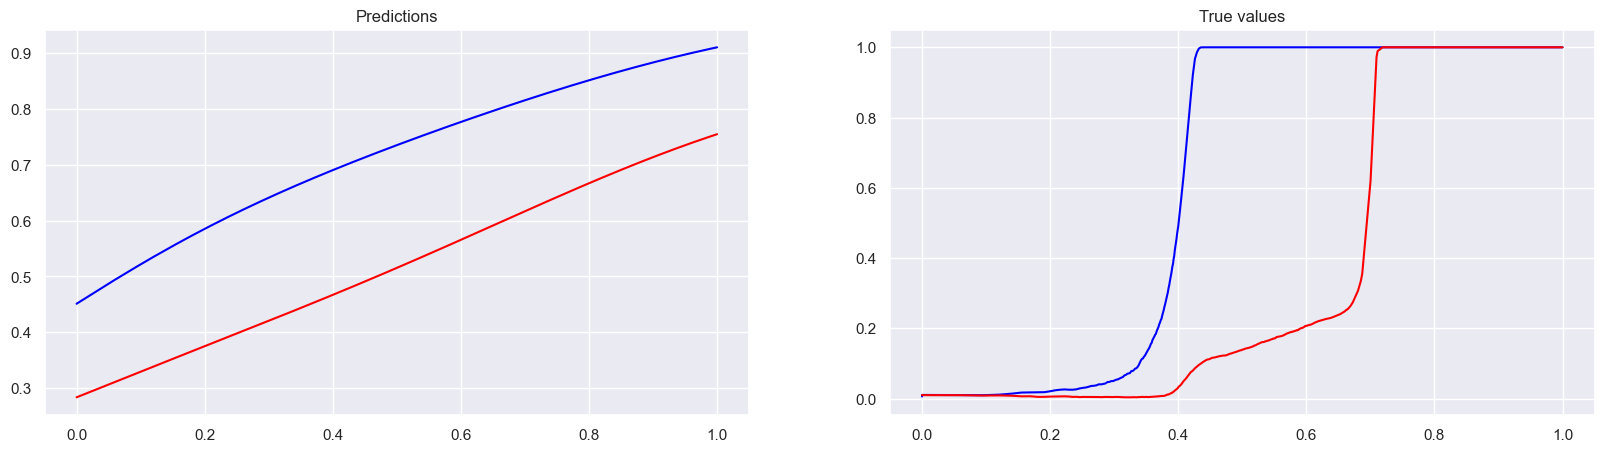

Epoch 2 - loss: 0.16184575855731964


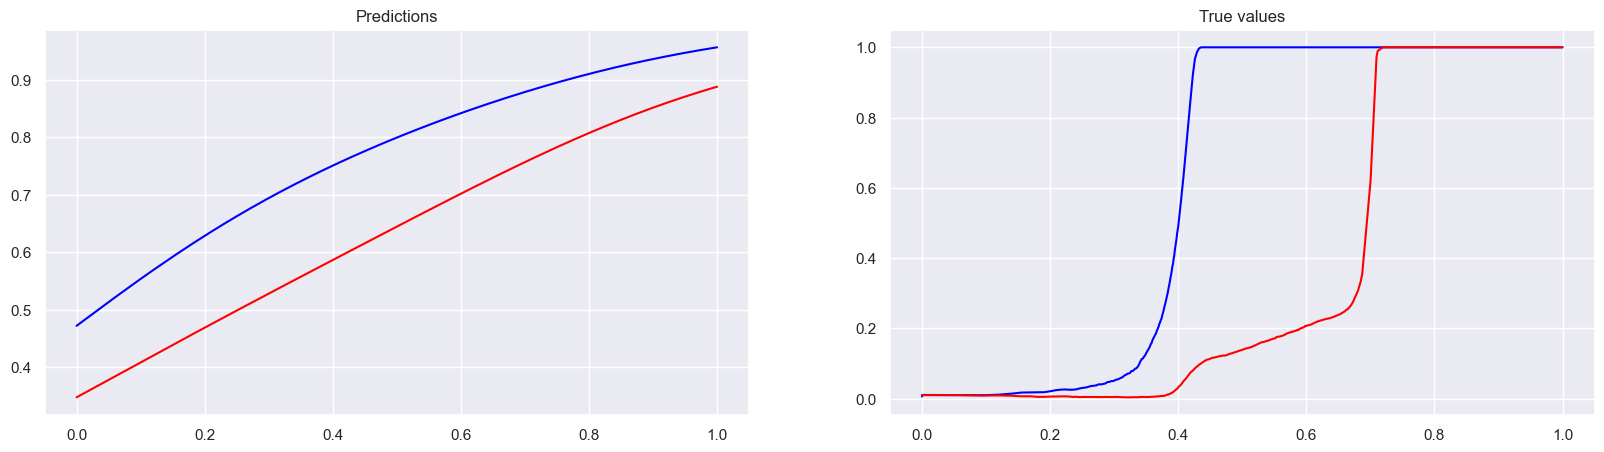

Epoch 3 - loss: 0.16423299908638


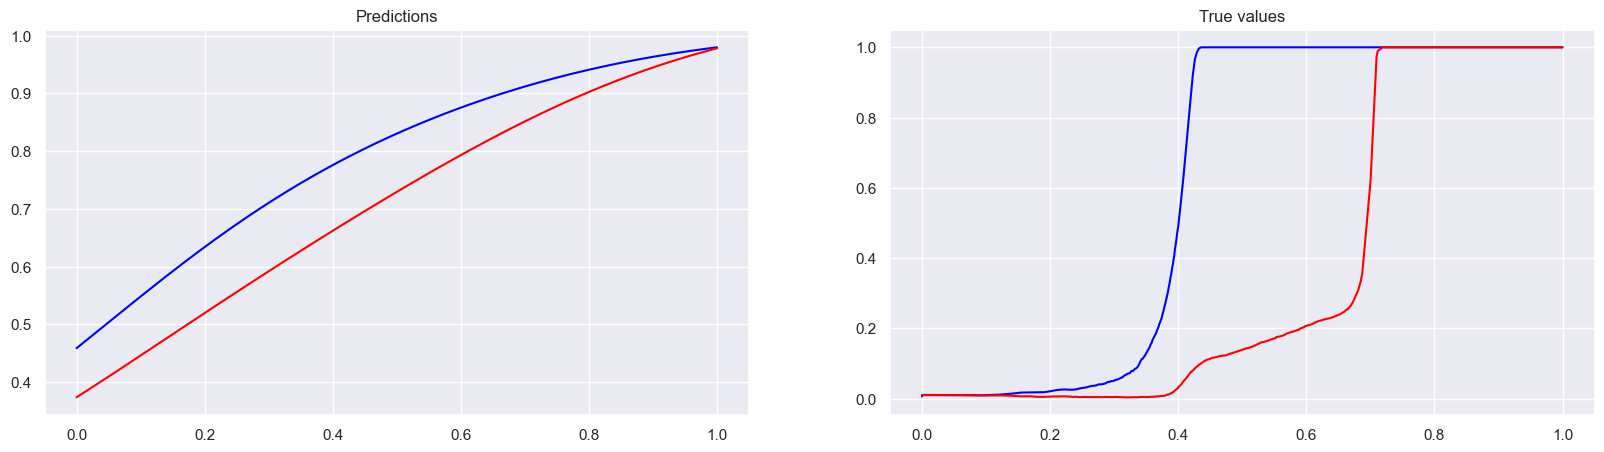

Epoch 4 - loss: 0.18542727828025818


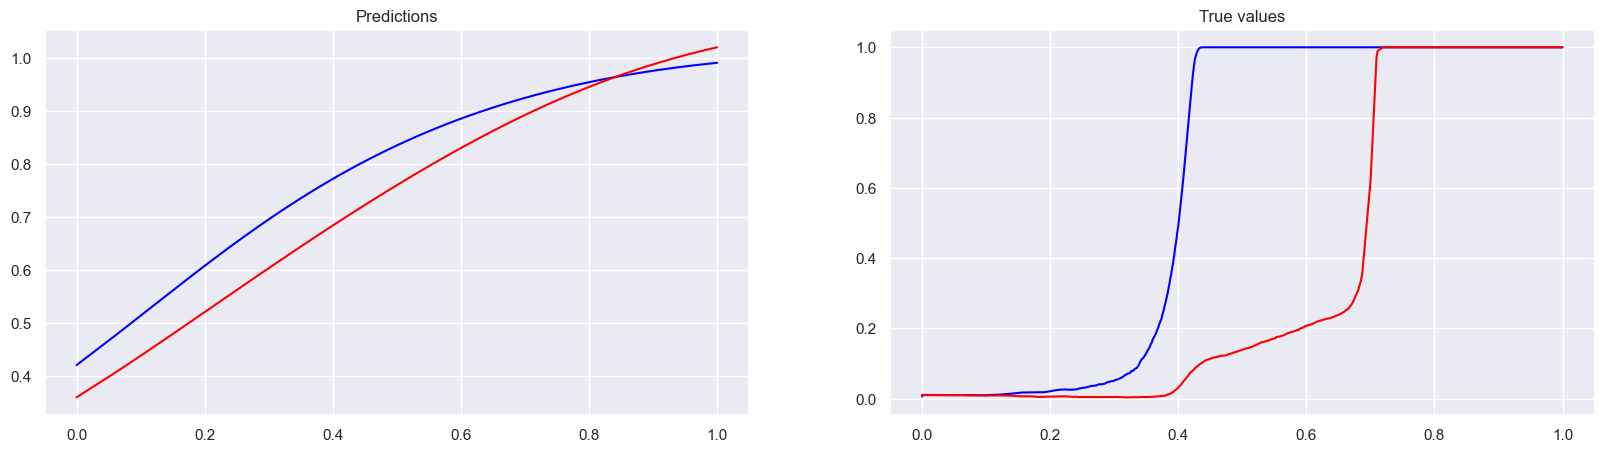

Epoch 5 - loss: 0.19338259100914001


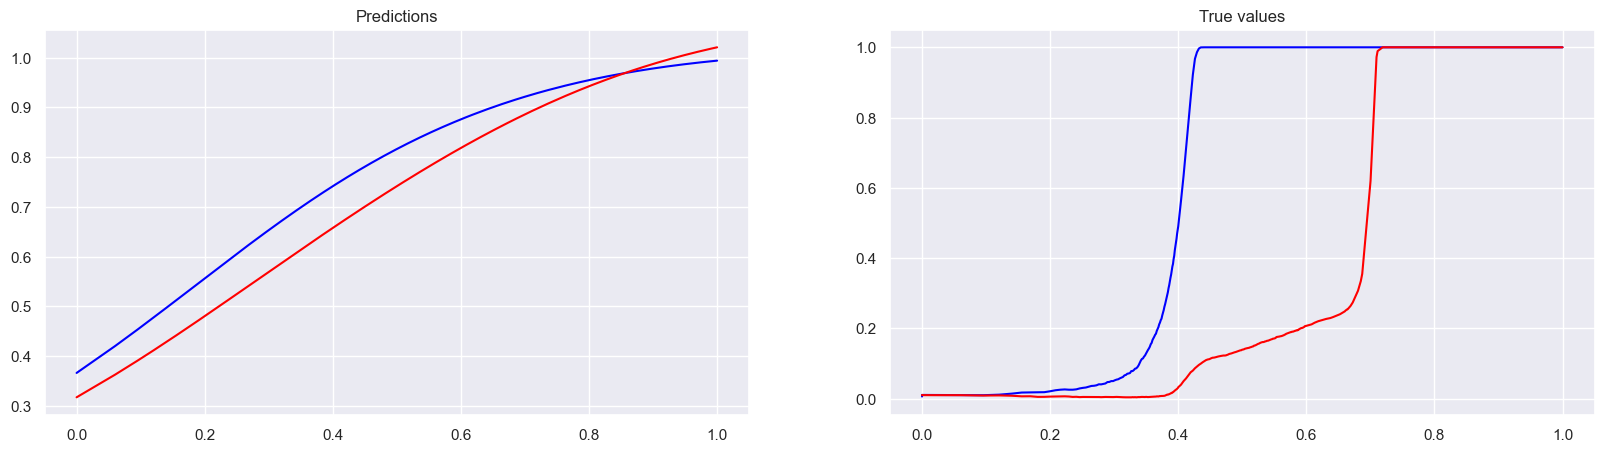

Epoch 6 - loss: 0.1793684959411621


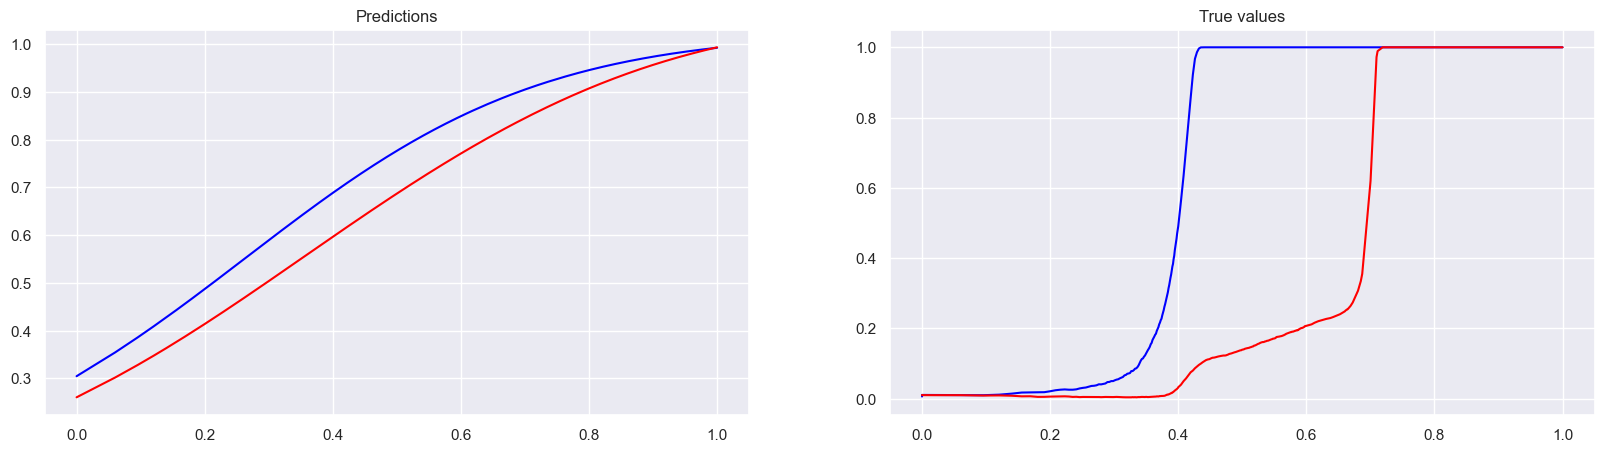

Epoch 7 - loss: 0.15149371325969696


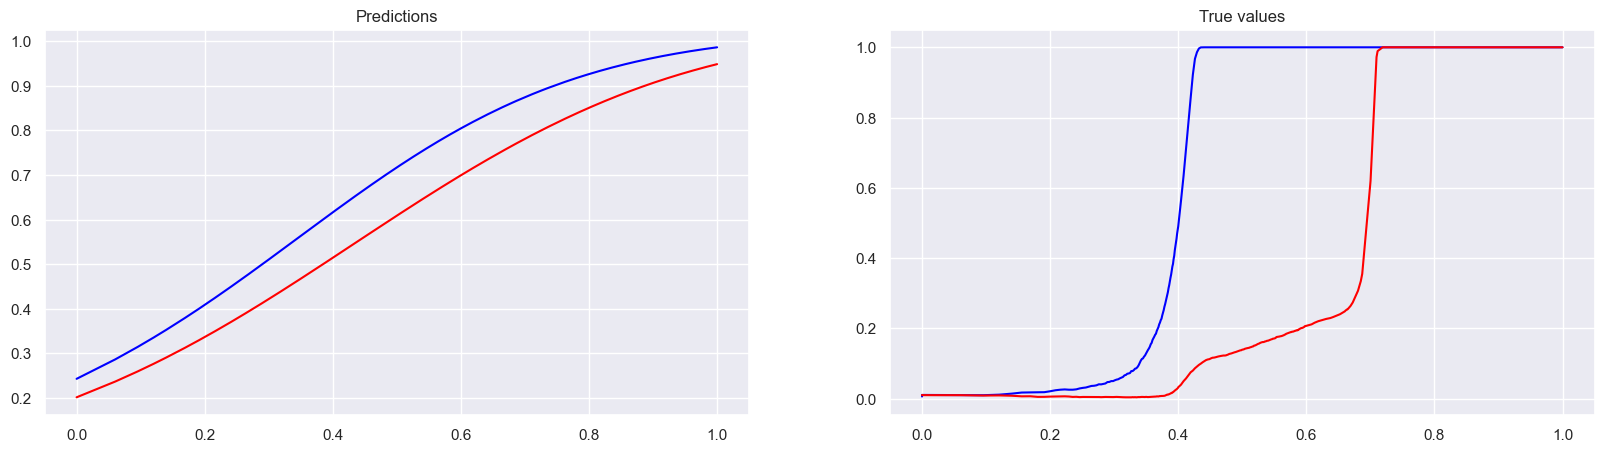

Epoch 8 - loss: 0.12381375581026077


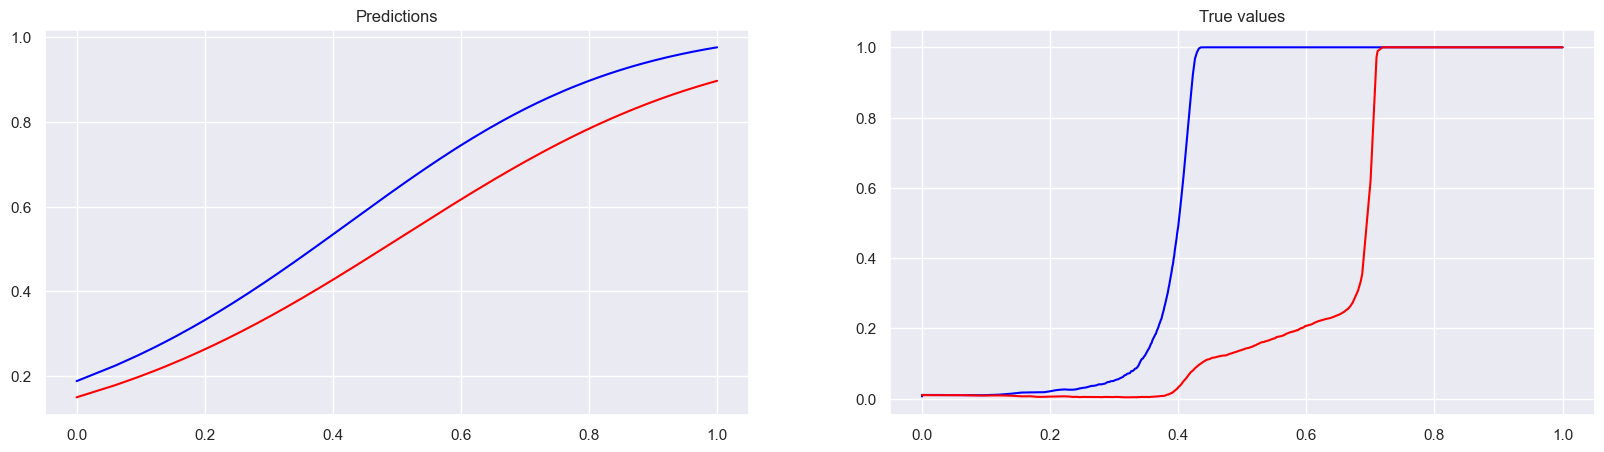

Epoch 9 - loss: 0.10855968296527863


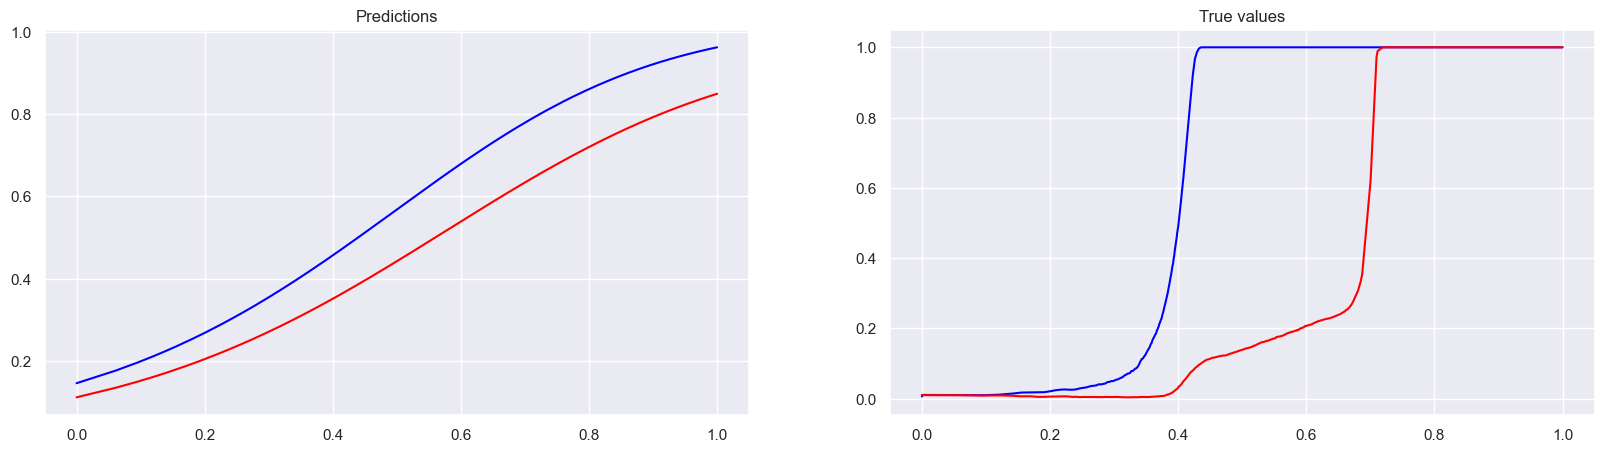

Epoch 10 - loss: 0.10958917438983917


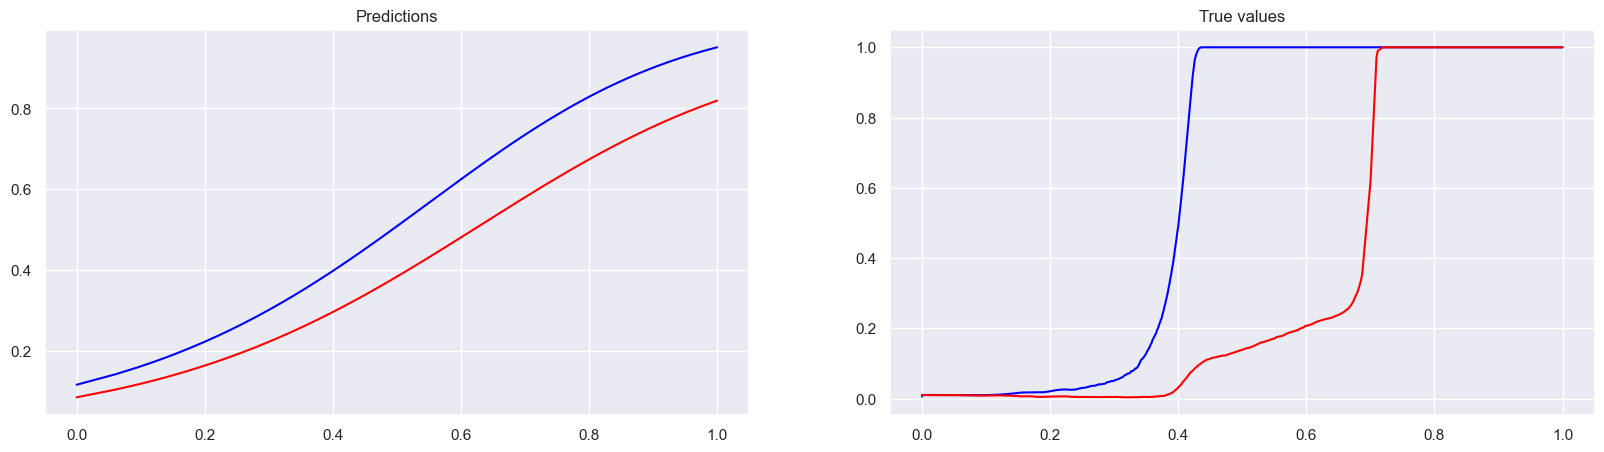

Epoch 20 - loss: 0.06412059813737869


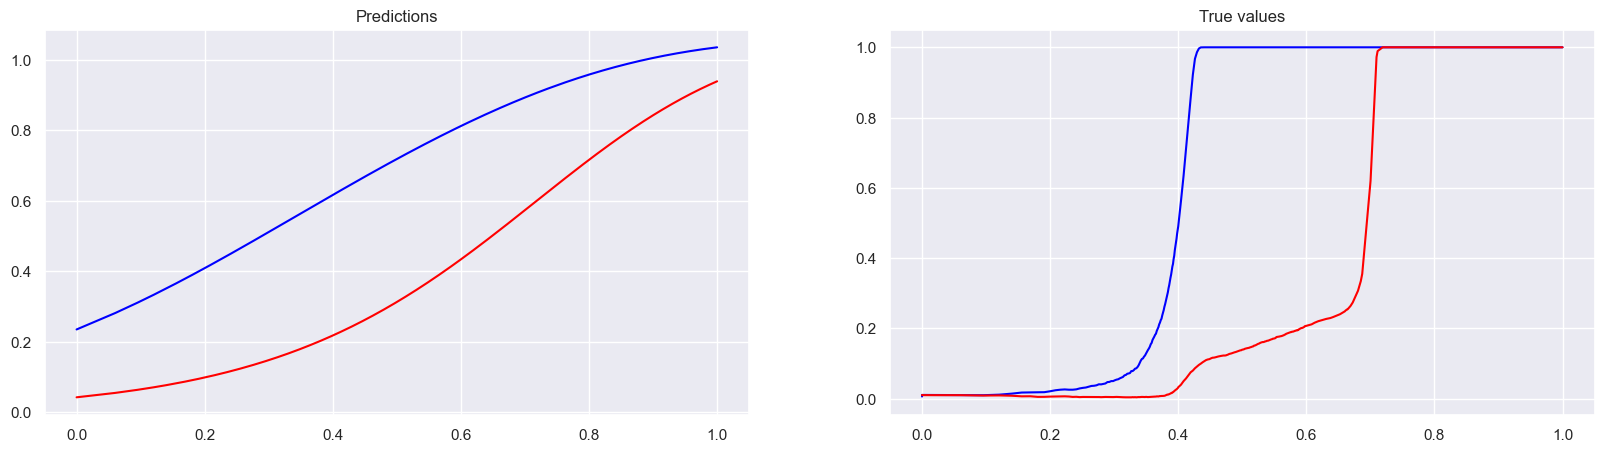

Epoch 30 - loss: 0.05232127010822296


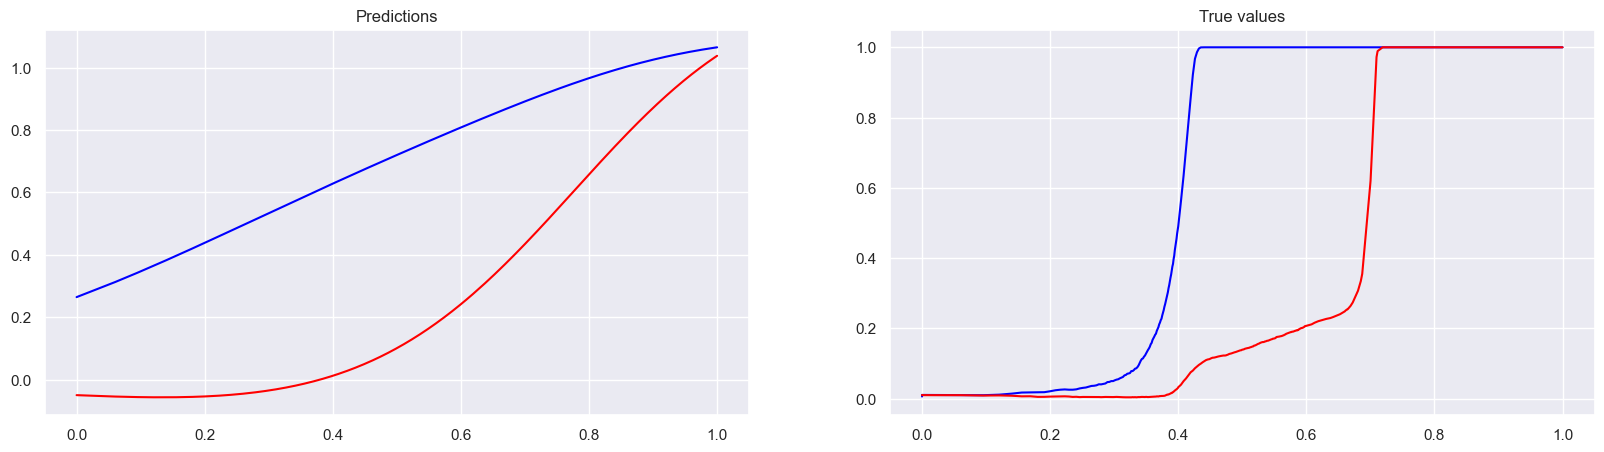

Epoch 40 - loss: 0.03760728985071182


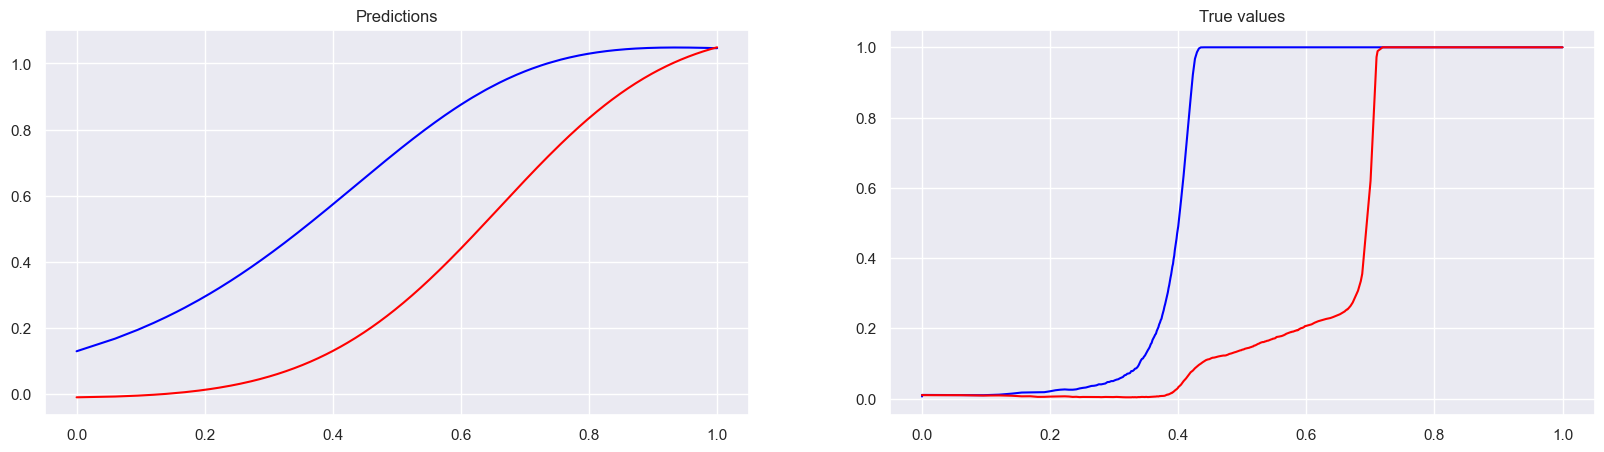

Epoch 50 - loss: 0.030200548470020294


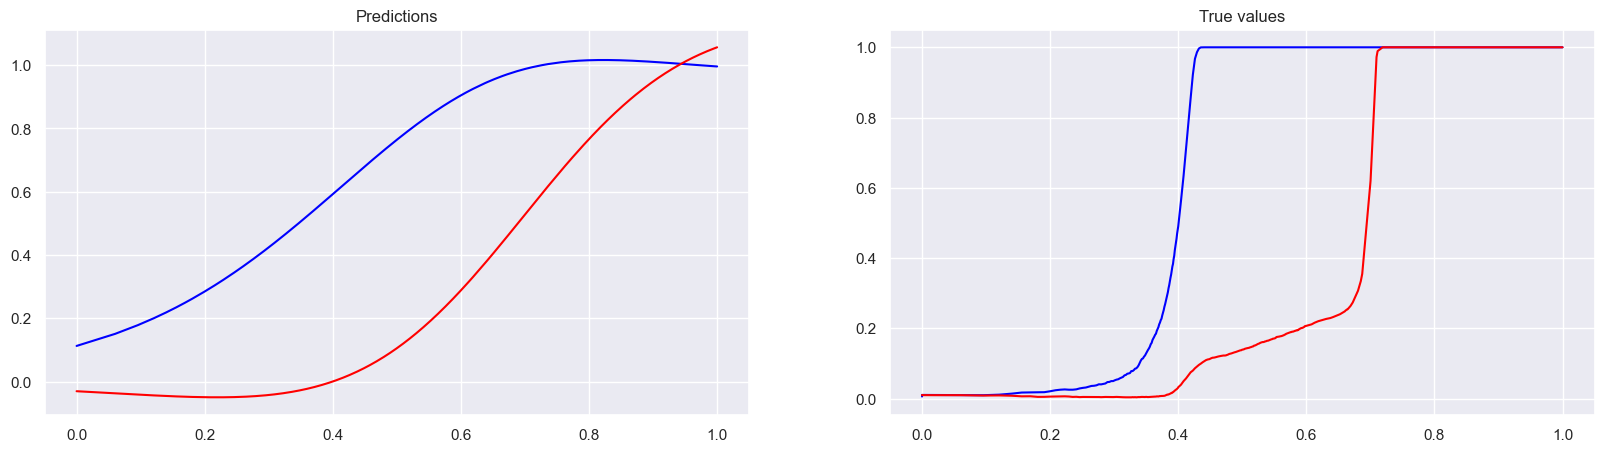

Epoch 60 - loss: 0.02660812810063362


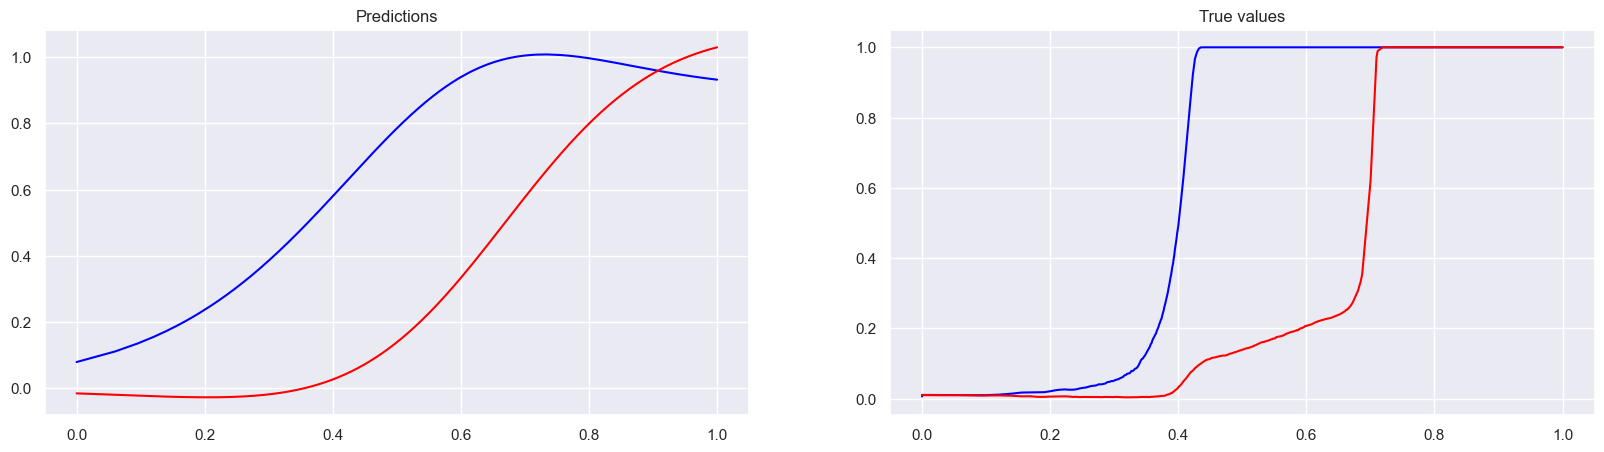

Epoch 70 - loss: 0.023460371419787407


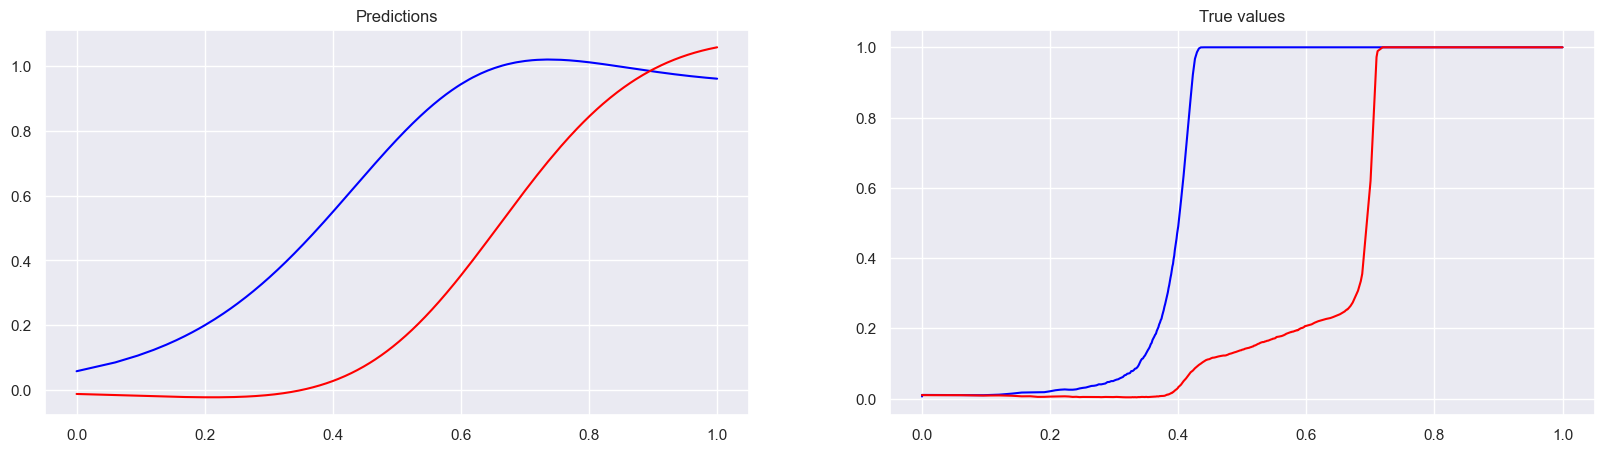

Epoch 80 - loss: 0.021134715527296066


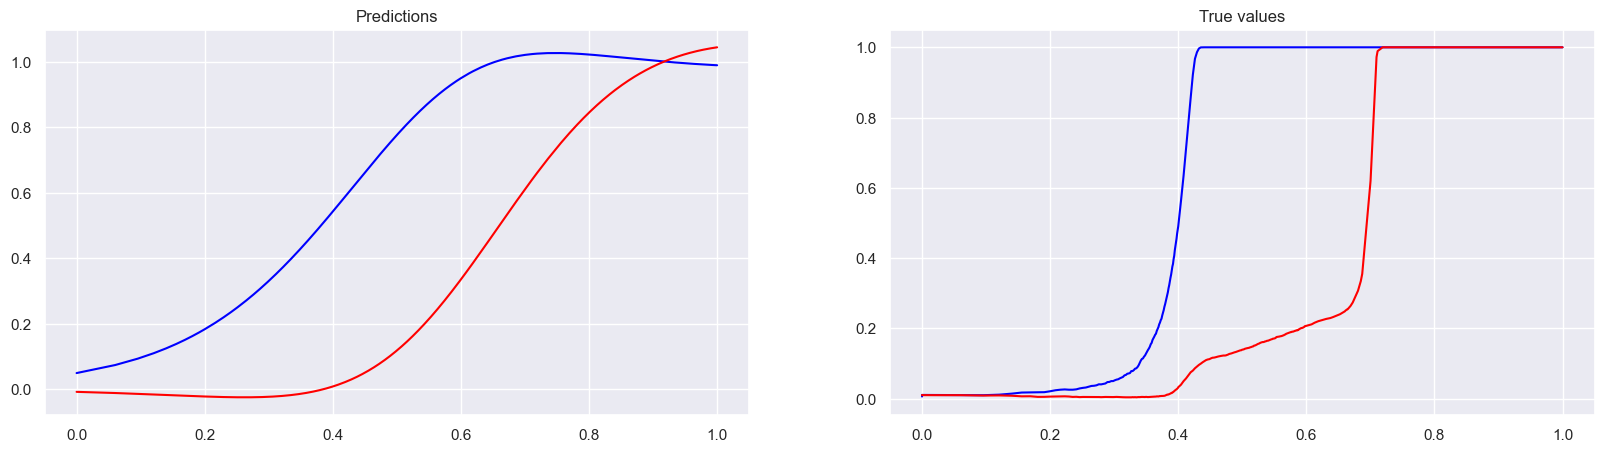

KeyboardInterrupt: 

In [52]:
pl_model = PatternLearningModel(num_patterns=3)
pl_model.fit(rescaled_run)
